In [1]:
import glob
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

In [2]:
# !pip install albumentations torchsummary tensorboard

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_dir = '/content/drive/MyDrive/Notebooks/IKIUSelfDrivingCar/'

root_dir_dataset = os.path.join(base_dir, 'Dataset')
root_dir_augmented = os.path.join(base_dir, 'Augmented_Dataset')

## Dataset Stats

In [ ]:
def calculate_dataset_stats(dataset_dir):
    sum_r = sum_g = sum_b = 0.0
    sum_sq_r = sum_sq_g = sum_sq_b = 0.0
    total_pixels = 0
    processed_files = 0
    problematic_files = []

    total_images = 0
    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)
        if os.path.isdir(class_path):
            total_images += len([f for f in os.listdir(class_path)
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    with tqdm(total=total_images, desc="Processing Images",
             unit="img", dynamic_ncols=True) as pbar:

        for class_dir in os.listdir(dataset_dir):
            class_path = os.path.join(dataset_dir, class_dir)
            if not os.path.isdir(class_path):
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)

                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    problematic_files.append(f"{img_path} - Not an image")
                    pbar.update(1)
                    continue

                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        raise ValueError("OpenCV failed to read image")

                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    if img.dtype != np.uint8:
                        raise ValueError(f"Unexpected dtype: {img.dtype}")

                    img = img.astype(np.float32) / 255.0

                    sum_r += np.sum(img[:, :, 0])
                    sum_g += np.sum(img[:, :, 1])
                    sum_b += np.sum(img[:, :, 2])

                    sum_sq_r += np.sum(np.square(img[:, :, 0]))
                    sum_sq_g += np.sum(np.square(img[:, :, 1]))
                    sum_sq_b += np.sum(np.square(img[:, :, 2]))

                    total_pixels += img.shape[0] * img.shape[1]
                    processed_files += 1

                except Exception as e:
                    problematic_files.append(f"{img_path} - {str(e)}")

                finally:
                    pbar.update(1)
                    pbar.set_postfix({
                        'Processed': processed_files,
                        'Errors': len(problematic_files),
                        'Current': os.path.basename(class_dir)
                    })

    if total_pixels == 0:
        raise ValueError("No valid images processed - check dataset path or file formats")

    mean = [
        round(sum_r / total_pixels, 5),
        round(sum_g / total_pixels, 5),
        round(sum_b / total_pixels, 5)
    ]

    std = [
        round(np.sqrt((sum_sq_r / total_pixels) - (mean[0] ** 2)), 5),
        round(np.sqrt((sum_sq_g / total_pixels) - (mean[1] ** 2)), 5),
        round(np.sqrt((sum_sq_b / total_pixels) - (mean[2] ** 2)), 5)
    ]

    print("\nValidation Summary:")
    print(f"Total images attempted: {total_images}")
    print(f"Successfully processed: {processed_files}")
    print(f"Problematic files: {len(problematic_files)}")

    if problematic_files:
        print("\nFirst 5 errors:")
        for error in problematic_files[:5]:
            print(f" - {error}")

    return mean, std

In [ ]:
dataset_dir = 'Dataset'
mean, std = calculate_dataset_stats(dataset_dir)

dataset_mean = [round(float(m), 5) for m in mean]
dataset_std = [round(float(s), 5) for s in std]

print("\nDataset Statistics:")
print("Dataset Mean (RGB):", dataset_mean)
print("Dataset Std (RGB):", dataset_std)

assert all(0 <= m <= 1 for m in dataset_mean), "Mean values out of [0,1] range"
assert all(0 <= s <= 1 for s in dataset_std), "Std values out of [0,1] range"

assert abs(mean[0]*255 - 0.57119 * 255) < 0.1, "Red mean mismatch"
assert abs(mean[1]*255 - 0.57445 * 255) < 0.1, "Green mean mismatch"
assert abs(mean[2]*255 - 0.60537 * 255) < 0.1, "Blue mean mismatch"

assert abs(std[0]*255 - 0.11762 * 255) < 0.1, "Red std mismatch"
assert abs(std[1]*255 - 0.12342 * 255) < 0.1, "Green std mismatch"
assert abs(std[2]*255 - 0.11999 * 255) < 0.1, "Blue std mismatch"

print("\nBasic validation checks passed!")

In [5]:
dataset_mean = [0.57121, 0.57445, 0.60535]
dataset_std = [0.11756, 0.12333, 0.11987]

imageNet_mean = [0.485, 0.456, 0.406]
imageNet_std = [0.229, 0.224, 0.225]

## Traffic Sign Dataset

### Data Augmentation

In [6]:
transform_album = A.Compose(
    [
        A.Resize(32, 32),
        A.Affine(
            translate_percent=0.02,
            scale=(0.95, 1.05),
            fill=128,
            p=0.3
        ),
        A.Perspective(
            scale=(0.05, 0.1),
            keep_size=True,
            fill=128,
            p=0.4
        ),
        # A.HueSaturationValue(
        #     hue_shift_limit=2,
        #     sat_shift_limit=3,
        #     val_shift_limit=3,
        #     p=0.2
        # ),
        A.RandomBrightnessContrast(
            brightness_limit=(0, 0.2),
            contrast_limit=0.1,
            p=0.2
        ),
        A.RGBShift(
          r_shift_limit=2,
          g_shift_limit=2,
          b_shift_limit=2,
          p=0.2
        ),
        A.GaussianBlur(
            blur_limit=(3, 7),
            p=0.2
        ),
        A.GaussNoise(
            std_range=(0.01, 0.02),
            mean_range=(0.04, 0.06),
            p=0.2
        ),
        # A.CoarseDropout(
        #     num_holes_range=(1, 2),
        #     hole_height_range=(4, 6),
        #     hole_width_range=(4, 6),
        #     fill=128,
        #     p=0.2
        # ),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        ToTensorV2()
    ],
    p=1
)

In [7]:
transform_simple = A.Compose(
    [
        A.Resize(32, 32),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        ToTensorV2()
    ],
    p=1
)

In [9]:
root_dir = root_dir_dataset
output_dir = root_dir_augmented
os.makedirs(output_dir, exist_ok=True)

images_path_list = []
labels_path_list = []
class_idx = {}
augmentation_count = 5

class_names = sorted([d for d in os.listdir(root_dir)
                      if os.path.isdir(os.path.join(root_dir, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    images_tmp = os.path.join(root_dir, class_name, "*.png")
    images_paths = glob.glob(images_tmp)

    for img_path in images_paths:
        images_path_list.append(img_path)
        labels_path_list.append(cls_idx)

In [10]:
class_idx

{0: 'barred_area',
 1: 'cross_walk',
 2: 'go_straight',
 3: 'no_passing_zone_beginning',
 4: 'parking_zone',
 5: 'priority_over',
 6: 'steep_hill_downhill',
 7: 'steep_hill_uphill',
 8: 'stop',
 9: 'tunnel_beginning',
 10: 'turn_left',
 11: 'turn_right'}

In [ ]:
pbar = tqdm(total=len(images_path_list) * augmentation_count,
            desc="Augmenting Images",
            unit="img",
            dynamic_ncols=True)

for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    if not os.path.exists(class_dir):
        raise RuntimeError(f"Failed to create directory: {class_dir}")

for img_path in images_path_list:
    class_name = os.path.basename(os.path.dirname(img_path))
    base_name = os.path.splitext(os.path.basename(img_path))[0]

    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}")
        pbar.update(augmentation_count)
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = os.path.splitext(os.path.basename(img_path))[0]

    for aug_num in range(1, augmentation_count + 1):
        transformed = transform_album(image=img)
        transformed_img = transformed['image']

        transformed_img = transformed_img.permute(1, 2, 0).numpy()
        transformed_img = (transformed_img * np.array(dataset_std) + np.array(dataset_mean))
        transformed_img = np.clip(transformed_img * 255, 0, 255).astype(np.uint8)

        new_filename = f"{base_name}_aug_{aug_num:02d}.png"
        new_path = os.path.join(output_dir, class_name, new_filename)

        if not os.path.exists(os.path.dirname(new_path)):
            os.makedirs(os.path.dirname(new_path), exist_ok=True)

        try:
            save_success = cv2.imwrite(new_path, cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR))
            if not save_success:
                Image.fromarray(transformed_img).save(new_path)
                print(f"Used PIL fallback for {new_path}")
        except Exception as save_error:
            print(f"Failed to save {new_path}: {str(save_error)}")
            continue

        pbar.update(1)
        pbar.set_postfix_str(f"Processing: {class_name}/{new_filename}")

pbar.close()
output_files = glob.glob(os.path.join(output_dir, "**", "*.png"), recursive=True)
print(f"\nAugmentation complete. {len(images_path_list)} → {len(images_path_list)*augmentation_count} files")
print(f"Augmented images saved in: {os.path.abspath(output_dir)}")

In [ ]:
images_path_list = []
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        images_path_list.extend(glob.glob(os.path.join(class_path, "*.png")))

pbar = tqdm(total=len(images_path_list),
           desc="Processing Images",
           unit="img",
           dynamic_ncols=True)

for img_path in images_path_list:
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        transformed = transform_simple(image=img)
        processed_img = transformed['image']

        processed_img = processed_img.permute(1, 2, 0).numpy()
        processed_img = (processed_img * dataset_std + dataset_mean) * 255
        processed_img = processed_img.clip(0, 255).astype(np.uint8)

        cv2.imwrite(img_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        pbar.update(1)

    except Exception as e:
        print(f"\nError processing {img_path}: {str(e)}")
        continue

pbar.close()
print(f"\nProcessing complete. {len(images_path_list)} images replaced")
print(f"Original images overwritten in: {os.path.abspath(root_dir)}")

### Dataset Class

In [11]:
class TrafficSignDB(Dataset):
    def __init__(self, images_path_list, labels_path_list, transform=None):
        self.images_path_list = images_path_list
        self.labels_path_list = labels_path_list
        self.transform = transform
        self.idx_to_class = self._create_label_mapping()

    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}

    def __len__(self) -> int:
        return len(self.images_path_list)

    def __getitem__(self, index) -> tuple[torch.Tensor, int]:
        path = self.images_path_list[index]
        label = self.labels_path_list[index]

        try:
            import cv2
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.transform:
                if isinstance(self.transform, A.Compose):
                    # Albumentations Pipeline
                    augmented = self.transform(image=image)
                    image = augmented["image"]
                else:
                    # PyTorch PIL
                    from PIL import Image
                    image = Image.open(path).convert("RGB")
                    image = self.transform(image)
            else:
                from albumentations.pytorch import ToTensorV2
                image = ToTensorV2()(image=image)["image"]

        except Exception as e:
            print(f"Error processing image {path}: {e}")
            image = torch.zeros(3, 32, 32)

        return image, label

    def get_class_name(self, label_idx):
        return self.idx_to_class.get(label_idx, "unknown")

In [12]:
root_dir_dataset = root_dir_dataset
root_dir_augmented = root_dir_augmented

train_percentage = 0.2

images_path_list_train = []
labels_path_list_train = []
images_path_list_test = []
labels_path_list_test = []
class_idx = {}

class_names = sorted([d for d in os.listdir(root_dir_dataset)
                      if os.path.isdir(os.path.join(root_dir_dataset, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name

    # Augmented images (training)
    aug_pattern = os.path.join(root_dir_augmented, class_name, "*.png")
    aug_images_paths = glob.glob(aug_pattern)
    for img_path in aug_images_paths:
        images_path_list_train.append(img_path)
        labels_path_list_train.append(cls_idx)

    # Dataset images (training and testing)
    orig_pattern = os.path.join(root_dir_dataset, class_name, "*.png")
    orig_images_paths = sorted(glob.glob(orig_pattern))

    train_paths, test_paths = train_test_split(
        orig_images_paths,
        train_size=train_percentage,
        random_state=42,
        shuffle=True
    )

    for img_path in train_paths:
        images_path_list_train.append(img_path)
        labels_path_list_train.append(cls_idx)

    for img_path in test_paths:
        images_path_list_test.append(img_path)
        labels_path_list_test.append(cls_idx)

In [13]:
train_dataset = TrafficSignDB(
    images_path_list=images_path_list_train,
    labels_path_list=labels_path_list_train,
    transform=transform_simple
)

test_dataset = TrafficSignDB(
    images_path_list=images_path_list_test,
    labels_path_list=labels_path_list_test,
    transform=transform_simple
)

In [14]:
print("Class Mapping (idx -> class):")
print(train_dataset.idx_to_class)
print("\nTrain Dataset Files:")
for path, label in zip(images_path_list_train, labels_path_list_train):
    print(f"Path: {path} | Label: {label} | Class: {class_names[label]}")
print("\nTest Dataset Files:")
for path, label in zip(images_path_list_test, labels_path_list_test):
    print(f"Path: {path} | Label: {label} | Class: {class_names[label]}")

Output hidden; open in https://colab.research.google.com to view.

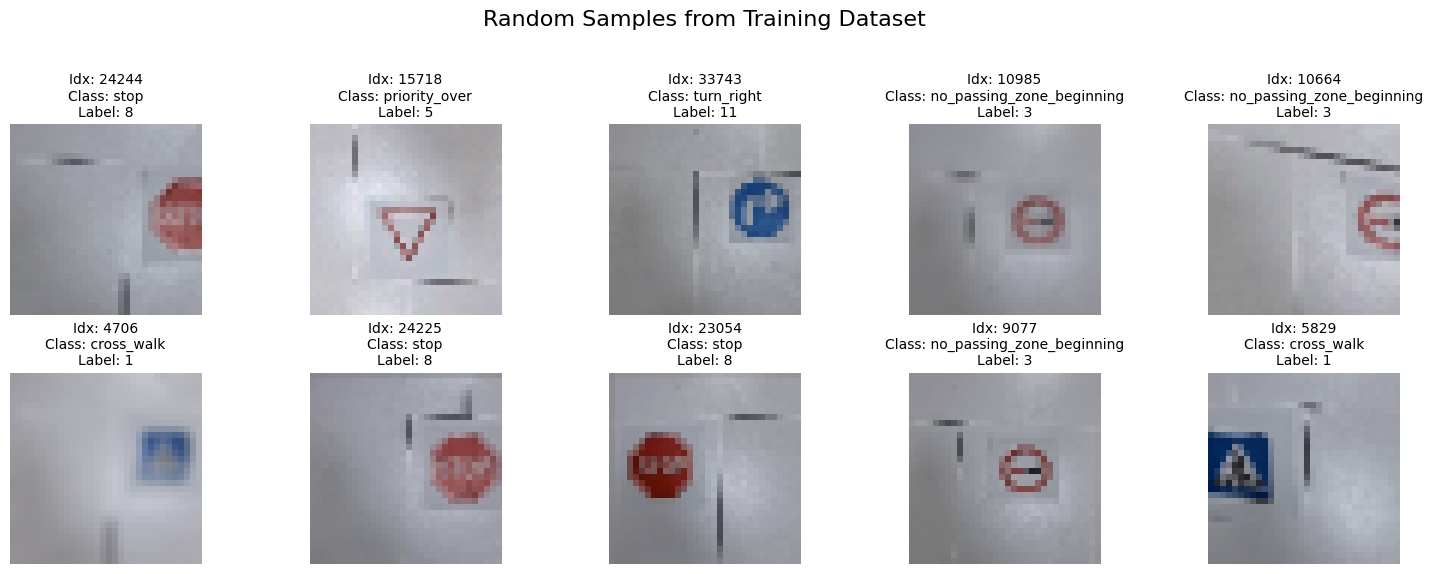

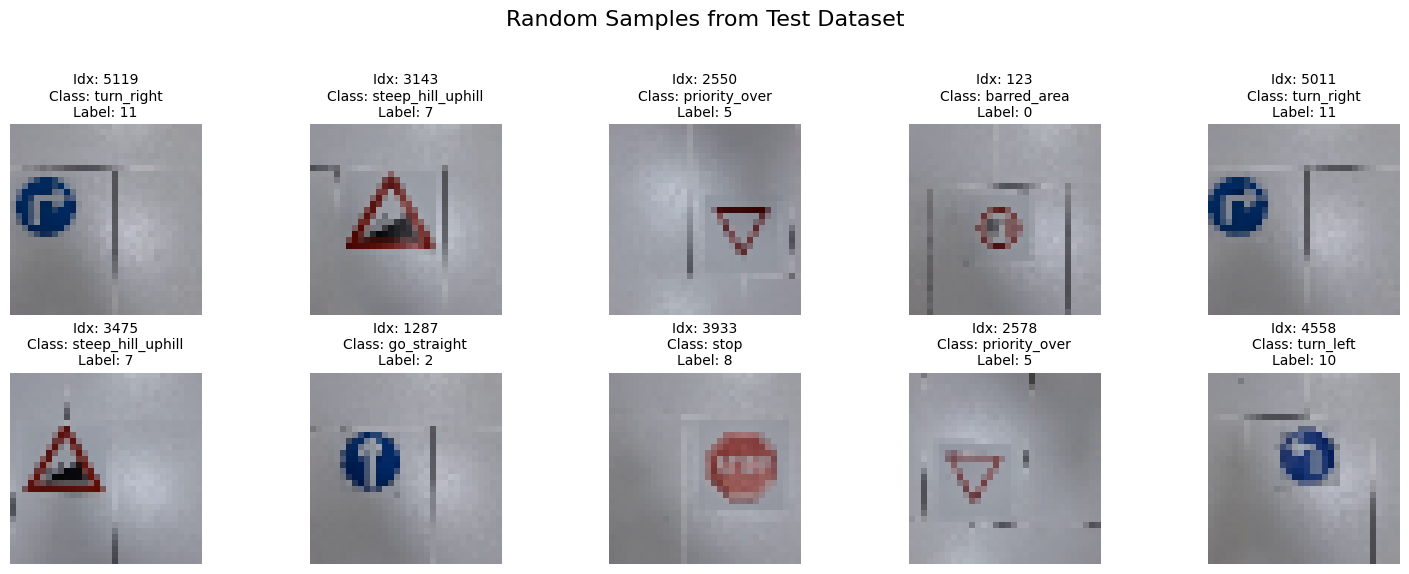

In [15]:
def denormalize_image(image_tensor, mean, std):
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def show_random_samples_subplot(dataset, num_samples=10, dataset_name="Dataset"):
    indices = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        class_name = dataset.get_class_name(label)
        if isinstance(image, torch.Tensor):
            image = denormalize_image(image, dataset_mean, dataset_std)
        axes[i].imshow(image)
        axes[i].set_title(f"Idx: {idx}\nClass: {class_name}\nLabel: {label}", fontsize=10)
        axes[i].axis('off')

    plt.suptitle(f"Random Samples from {dataset_name}", fontsize=16)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95), w_pad=2)
    plt.show()

show_random_samples_subplot(train_dataset, num_samples=10, dataset_name="Training Dataset")
show_random_samples_subplot(test_dataset, num_samples=10, dataset_name="Test Dataset")

In [16]:
from collections import Counter

train_class_counts = Counter(labels_path_list_train)
test_class_counts = Counter(labels_path_list_test)
train_total = len(images_path_list_train)
test_total = len(images_path_list_test)

print("\nTraining Dataset Class Distribution:")
for idx in range(len(class_names)):
    class_name = class_names[idx]
    count = train_class_counts.get(idx, 0)
    print(f"Class '{class_name}' (Index {idx}): {count} samples")

print("\nTest Dataset Class Distribution:")
for idx in range(len(class_names)):
    class_name = class_names[idx]
    count = test_class_counts.get(idx, 0)
    print(f"Class '{class_name}' (Index {idx}): {count} samples")

print(f"\nTraining Dataset Size: {train_total} samples")
print(f"Test Dataset Size: {test_total} samples")
print(f"Total Combined Size: {train_total + test_total} samples")


Training Dataset Class Distribution:
Class 'barred_area' (Index 0): 3255 samples
Class 'cross_walk' (Index 1): 3116 samples
Class 'go_straight' (Index 2): 2656 samples
Class 'no_passing_zone_beginning' (Index 3): 2990 samples
Class 'parking_zone' (Index 4): 2615 samples
Class 'priority_over' (Index 5): 3073 samples
Class 'steep_hill_downhill' (Index 6): 2355 samples
Class 'steep_hill_uphill' (Index 7): 2626 samples
Class 'stop' (Index 8): 2953 samples
Class 'tunnel_beginning' (Index 9): 3218 samples
Class 'turn_left' (Index 10): 3109 samples
Class 'turn_right' (Index 11): 2993 samples

Test Dataset Class Distribution:
Class 'barred_area' (Index 0): 501 samples
Class 'cross_walk' (Index 1): 488 samples
Class 'go_straight' (Index 2): 408 samples
Class 'no_passing_zone_beginning' (Index 3): 460 samples
Class 'parking_zone' (Index 4): 403 samples
Class 'priority_over' (Index 5): 473 samples
Class 'steep_hill_downhill' (Index 6): 363 samples
Class 'steep_hill_uphill' (Index 7): 404 samples

## Training the Model

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter


Dataset Verification:
Total samples: 34959
Sample paths: ['/content/drive/MyDrive/Notebooks/IKIUSelfDrivingCar/Augmented_Dataset/barred_area/frame_0223_aug_05.png', '/content/drive/MyDrive/Notebooks/IKIUSelfDrivingCar/Augmented_Dataset/barred_area/frame_0232_aug_05.png', '/content/drive/MyDrive/Notebooks/IKIUSelfDrivingCar/Augmented_Dataset/barred_area/frame_0218_aug_04.png']


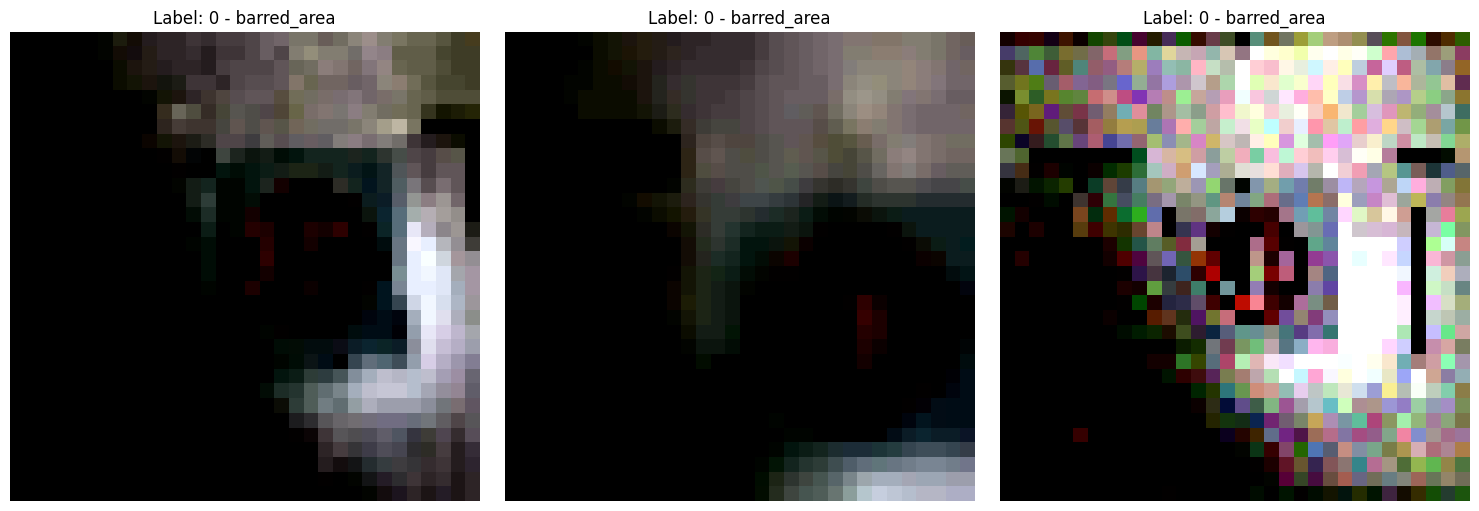


Dataset Verification:
Total samples: 5389
Sample paths: ['/content/drive/MyDrive/Notebooks/IKIUSelfDrivingCar/Dataset/barred_area/frame_0449.png', '/content/drive/MyDrive/Notebooks/IKIUSelfDrivingCar/Dataset/barred_area/frame_0487.png', '/content/drive/MyDrive/Notebooks/IKIUSelfDrivingCar/Dataset/barred_area/frame_0216.png']


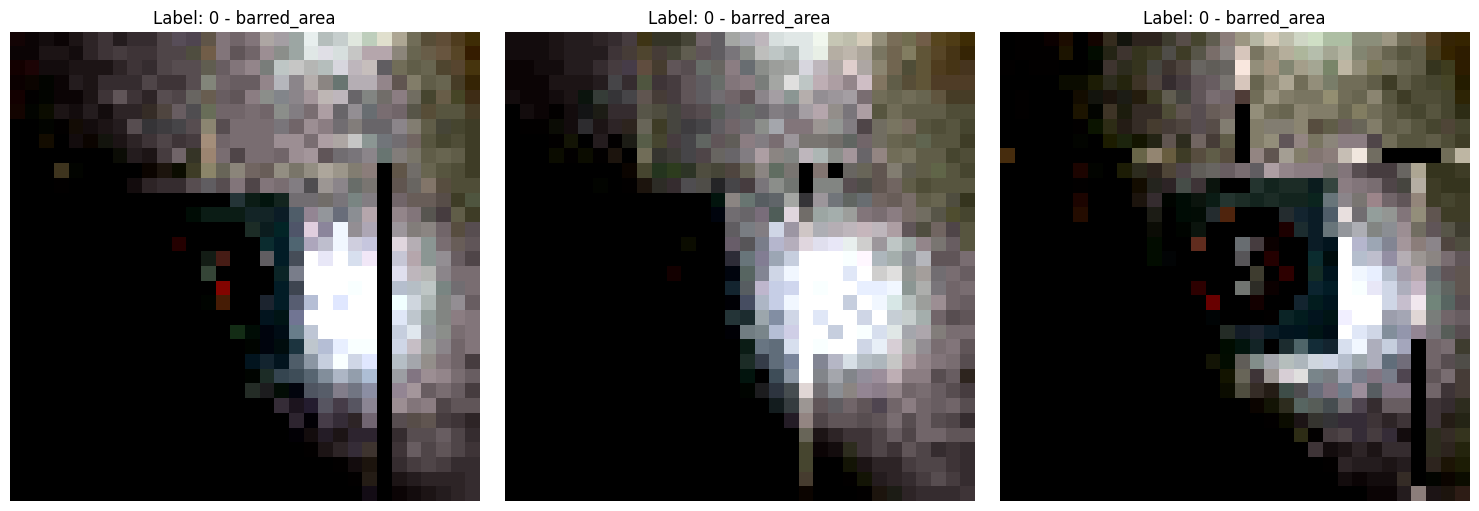

In [18]:
def verify_dataset(dataset, num_samples=3):
    print("\nDataset Verification:")
    print(f"Total samples: {len(dataset)}")
    print(f"Sample paths: {dataset.images_path_list[:3]}")

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        image, label = dataset[i]
        plt.subplot(1, num_samples, i+1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title(f"Label: {label} - {dataset.get_class_name(label)}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

verify_dataset(train_dataset)
verify_dataset(test_dataset)

In [19]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(TrafficSignCNN, self).__init__()

        self.conv0 = nn.Conv2d(in_channels=input_channels, out_channels=3, kernel_size=1, padding=0)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, padding=2)

        self.dropout = nn.Dropout(0.5)

        flattened_size = 8192 + 4096 + 2048

        self.fc1 = nn.Linear(flattened_size, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        print(f"Input shape: {x.shape}") if self.training else None

        x = F.relu(self.conv0(x))

        x = F.relu(self.conv1(x))

        x = F.relu(self.conv2(x))
        x2 = F.max_pool2d(x, kernel_size=2, stride=2)  # shape: (B,32,16,16)
        x2 = self.dropout(x2)


        x = F.relu(self.conv3(x2))

        x = F.relu(self.conv4(x))
        x4 = F.max_pool2d(x, kernel_size=2, stride=2)  # shape: (B,64,8,8)
        x4 = self.dropout(x4)

        x = F.relu(self.conv5(x4))

        x = F.relu(self.conv6(x))
        x6 = F.max_pool2d(x, kernel_size=2, stride=2)  # shape: (B,128,4,4)
        x6 = self.dropout(x6)

        flat2 = x2.view(x2.size(0), -1)
        flat4 = x4.view(x4.size(0), -1)
        flat6 = x6.view(x6.size(0), -1)

        x_concat = torch.cat((flat2, flat4, flat6), dim=1)  # (B, 14336)

        x = F.relu(self.fc1(x_concat))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        logits = self.fc3(x)

        return logits

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [22]:
batch_size = 32

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [23]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(dataloader.dataset), correct / total

In [24]:
def check_dimensions(loader):
    for inputs, _ in loader:
        print(f"Batch dimensions: {inputs.shape}")
        print(f"Data range: {inputs.min().item()} - {inputs.max().item()}")
        break

print("\nChecking training data dimensions:")
check_dimensions(train_loader)
print("\nChecking validation data dimensions:")
check_dimensions(test_loader)


Checking training data dimensions:
Batch dimensions: torch.Size([32, 3, 32, 32])
Data range: -4.919193744659424 - 2.2781457901000977

Checking validation data dimensions:
Batch dimensions: torch.Size([32, 3, 32, 32])
Data range: -5.01733922958374 - 1.846081018447876


In [25]:
def train_model(model, criterion, optimizer, num_epochs=20):
    writer = SummaryWriter()  # TensorBoard logging
    best_acc = 0.0

    for epoch in range(num_epochs):
        # Create one progress bar for the epoch
        tepoch = tqdm(
            train_loader,
            unit="batch",
            leave=True,
            desc=f"Epoch {epoch+1}/{num_epochs}",
            dynamic_ncols=True,
            # ncols=100,
            bar_format="{l_bar}{bar} | {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"
        )
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            tepoch.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{100.*correct/total:.2f}")

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = correct / total
        writer.add_scalar('Loss/train', epoch_loss, epoch)
        writer.add_scalar('Accuracy/train', epoch_acc, epoch)

        val_loss, val_acc = evaluate_model(model, criterion, test_loader)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_acc, epoch)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'traffic_sign_cnn.pth')

        print(f"Epoch {epoch+1}: Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    writer.close()
    return model

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = TrafficSignCNN(num_classes=len(class_names), input_channels=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

Using device: cuda


In [27]:
trained_model = train_model(model, criterion, optimizer, num_epochs=20)

Epoch 1/20:   0%|           | 0/1093 [00:00<?, ?batch/s]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   0%|           | 1/1093 [00:14<4:15:11, 14.02s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   0%|           | 5/1093 [00:25<1:23:11,  4.59s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   1%|           | 6/1093 [00:26<1:05:44,  3.63s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   1%|           | 9/1093 [00:38<1:08:56,  3.82s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   1%|           | 10/1093 [00:40<1:04:48,  3.59s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   1%|           | 13/1093 [00:49<59:29,  3.30s/batch]  

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   1%|▏          | 14/1093 [00:52<56:03,  3.12s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   2%|▏          | 17/1093 [01:04<1:04:42,  3.61s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   2%|▏          | 21/1093 [01:17<1:00:42,  3.40s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   2%|▏          | 22/1093 [01:18<54:03,  3.03s/batch]  

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   2%|▏          | 23/1093 [01:20<50:52,  2.85s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   2%|▏          | 25/1093 [01:28<1:00:01,  3.37s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   2%|▏          | 26/1093 [01:30<53:55,  3.03s/batch]  

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   2%|▏          | 27/1093 [01:31<47:34,  2.68s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   3%|▎          | 29/1093 [01:44<1:12:01,  4.06s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   3%|▎          | 33/1093 [01:56<1:02:10,  3.52s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   3%|▎          | 34/1093 [01:57<53:42,  3.04s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   3%|▎          | 37/1093 [02:08<58:30,  3.32s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   3%|▎          | 38/1093 [02:09<52:25,  2.98s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   4%|▍          | 41/1093 [02:20<58:02,  3.31s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   4%|▍          | 42/1093 [02:23<56:18,  3.21s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   4%|▍          | 45/1093 [02:33<55:39,  3.19s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   4%|▍          | 46/1093 [02:38<1:02:36,  3.59s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   4%|▍          | 49/1093 [02:44<51:28,  2.96s/batch]  

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   5%|▍          | 50/1093 [02:50<58:32,  3.37s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   5%|▍          | 53/1093 [02:57<52:24,  3.02s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   5%|▍          | 54/1093 [03:04<1:02:19,  3.60s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   5%|▌          | 57/1093 [03:10<51:17,  2.97s/batch]  

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   5%|▌          | 58/1093 [03:16<59:04,  3.42s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   6%|▌          | 61/1093 [03:23<51:11,  2.98s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   6%|▌          | 62/1093 [03:28<55:59,  3.26s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   6%|▌          | 65/1093 [03:37<55:35,  3.24s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   6%|▌          | 66/1093 [03:41<57:25,  3.36s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   6%|▌          | 67/1093 [03:42<50:16,  2.94s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   6%|▋          | 69/1093 [03:49<52:49,  3.09s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   6%|▋          | 70/1093 [03:53<53:32,  3.14s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   6%|▋          | 71/1093 [03:55<50:08,  2.94s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   7%|▋          | 73/1093 [04:01<51:45,  3.04s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   7%|▋          | 74/1093 [04:06<56:34,  3.33s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   7%|▋          | 75/1093 [04:08<51:07,  3.01s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   7%|▋          | 77/1093 [04:14<52:46,  3.12s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   7%|▋          | 78/1093 [04:19<58:30,  3.46s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   7%|▋          | 79/1093 [04:22<59:13,  3.50s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   7%|▋          | 81/1093 [04:26<46:52,  2.78s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   8%|▊          | 82/1093 [04:34<1:08:26,  4.06s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   8%|▊          | 85/1093 [04:38<45:00,  2.68s/batch]  

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   8%|▊          | 86/1093 [04:45<59:42,  3.56s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   8%|▊          | 87/1093 [04:49<1:01:02,  3.64s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   8%|▊          | 89/1093 [04:52<45:42,  2.73s/batch]  

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   8%|▊          | 90/1093 [04:58<59:02,  3.53s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   8%|▊          | 91/1093 [05:02<57:59,  3.47s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   9%|▊          | 93/1093 [05:05<46:20,  2.78s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   9%|▊          | 94/1093 [05:11<57:37,  3.46s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   9%|▊          | 95/1093 [05:16<1:02:14,  3.74s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   9%|▉          | 97/1093 [05:20<50:26,  3.04s/batch]  

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   9%|▉          | 98/1093 [05:24<56:57,  3.43s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   9%|▉          | 99/1093 [05:28<56:10,  3.39s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   9%|▉          | 101/1093 [05:31<46:21,  2.80s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   9%|▉          | 102/1093 [05:38<1:00:09,  3.64s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:   9%|▉          | 103/1093 [05:41<56:54,  3.45s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  10%|▉          | 105/1093 [05:45<48:16,  2.93s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  10%|▉          | 106/1093 [05:49<52:54,  3.22s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  10%|▉          | 107/1093 [05:52<52:12,  3.18s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  10%|▉          | 109/1093 [05:57<44:57,  2.74s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  10%|█          | 110/1093 [06:05<1:05:39,  4.01s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  10%|█          | 113/1093 [06:10<47:09,  2.89s/batch]  

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  10%|█          | 114/1093 [06:18<1:03:29,  3.89s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  11%|█          | 117/1093 [06:22<44:09,  2.71s/batch]  

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  11%|█          | 118/1093 [06:32<1:02:49,  3.87s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  11%|█          | 121/1093 [06:34<40:46,  2.52s/batch]  

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  11%|█          | 122/1093 [06:49<1:16:40,  4.74s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  12%|█▏         | 126/1093 [07:04<1:07:05,  4.16s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  12%|█▏         | 130/1093 [07:16<1:00:09,  3.75s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  12%|█▏         | 134/1093 [07:28<54:39,  3.42s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  13%|█▎         | 138/1093 [07:39<51:14,  3.22s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  13%|█▎         | 142/1093 [07:51<50:18,  3.17s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  13%|█▎         | 146/1093 [08:06<52:16,  3.31s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  14%|█▎         | 150/1093 [08:18<50:25,  3.21s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  14%|█▍         | 154/1093 [08:30<50:08,  3.20s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  14%|█▍         | 158/1093 [08:42<47:59,  3.08s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  15%|█▍         | 162/1093 [08:53<46:30,  3.00s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  15%|█▌         | 166/1093 [09:06<47:14,  3.06s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  16%|█▌         | 170/1093 [09:19<47:46,  3.11s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  16%|█▌         | 174/1093 [09:33<50:21,  3.29s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  16%|█▋         | 178/1093 [09:46<49:33,  3.25s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  17%|█▋         | 182/1093 [09:58<48:26,  3.19s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  17%|█▋         | 186/1093 [10:10<46:37,  3.08s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  17%|█▋         | 190/1093 [10:22<46:59,  3.12s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  18%|█▊         | 194/1093 [10:36<48:04,  3.21s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  18%|█▊         | 198/1093 [10:49<47:48,  3.21s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  18%|█▊         | 202/1093 [11:01<47:11,  3.18s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  19%|█▉         | 206/1093 [11:13<45:36,  3.09s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  19%|█▉         | 210/1093 [11:25<45:10,  3.07s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  20%|█▉         | 214/1093 [11:37<45:02,  3.07s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  20%|█▉         | 218/1093 [11:49<43:53,  3.01s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  20%|██         | 222/1093 [12:00<43:15,  2.98s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  21%|██         | 226/1093 [12:14<45:23,  3.14s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  21%|██         | 230/1093 [12:26<44:04,  3.06s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  21%|██▏        | 234/1093 [12:38<43:50,  3.06s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  22%|██▏        | 235/1093 [12:39<40:09,  2.81s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  22%|██▏        | 238/1093 [12:50<44:22,  3.11s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  22%|██▏        | 239/1093 [12:51<40:56,  2.88s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  22%|██▏        | 242/1093 [13:02<44:04,  3.11s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  22%|██▏        | 243/1093 [13:03<40:45,  2.88s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  23%|██▎        | 246/1093 [13:14<44:15,  3.14s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  23%|██▎        | 247/1093 [13:17<43:26,  3.08s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  23%|██▎        | 250/1093 [13:27<44:58,  3.20s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  23%|██▎        | 251/1093 [13:29<43:00,  3.07s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  23%|██▎        | 254/1093 [13:38<42:23,  3.03s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  23%|██▎        | 255/1093 [13:42<44:31,  3.19s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  24%|██▎        | 258/1093 [13:50<41:01,  2.95s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  24%|██▎        | 259/1093 [13:54<44:01,  3.17s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  24%|██▍        | 262/1093 [14:03<42:32,  3.07s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  24%|██▍        | 263/1093 [14:07<43:41,  3.16s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  24%|██▍        | 266/1093 [14:15<41:34,  3.02s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  24%|██▍        | 267/1093 [14:18<41:37,  3.02s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  25%|██▍        | 270/1093 [14:27<40:39,  2.96s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  25%|██▍        | 271/1093 [14:31<43:28,  3.17s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  25%|██▌        | 274/1093 [14:41<43:01,  3.15s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  25%|██▌        | 275/1093 [14:44<44:35,  3.27s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  25%|██▌        | 278/1093 [14:53<42:13,  3.11s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  26%|██▌        | 279/1093 [14:56<41:59,  3.10s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  26%|██▌        | 282/1093 [15:04<39:06,  2.89s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  26%|██▌        | 283/1093 [15:07<39:44,  2.94s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  26%|██▌        | 286/1093 [15:16<39:35,  2.94s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  26%|██▋        | 287/1093 [15:19<40:20,  3.00s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  26%|██▋        | 288/1093 [15:20<35:25,  2.64s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  27%|██▋        | 290/1093 [15:29<43:28,  3.25s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  27%|██▋        | 291/1093 [15:31<40:42,  3.05s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  27%|██▋        | 294/1093 [15:41<41:22,  3.11s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  27%|██▋        | 295/1093 [15:43<39:35,  2.98s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  27%|██▋        | 298/1093 [15:53<40:54,  3.09s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  27%|██▋        | 299/1093 [15:56<40:27,  3.06s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  28%|██▊        | 302/1093 [16:06<42:12,  3.20s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  28%|██▊        | 303/1093 [16:09<40:34,  3.08s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  28%|██▊        | 306/1093 [16:19<43:25,  3.31s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  28%|██▊        | 307/1093 [16:20<38:06,  2.91s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  28%|██▊        | 310/1093 [16:34<46:08,  3.54s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  29%|██▊        | 314/1093 [16:46<43:46,  3.37s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  29%|██▉        | 318/1093 [16:58<41:35,  3.22s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  29%|██▉        | 322/1093 [17:10<39:39,  3.09s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  30%|██▉        | 326/1093 [17:21<38:29,  3.01s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  30%|███        | 330/1093 [17:32<37:40,  2.96s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  30%|███        | 331/1093 [17:35<37:32,  2.96s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  31%|███        | 334/1093 [17:44<36:58,  2.92s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  31%|███        | 335/1093 [17:47<37:31,  2.97s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  31%|███        | 338/1093 [17:55<36:28,  2.90s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  31%|███        | 339/1093 [17:59<37:41,  3.00s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  31%|███▏       | 342/1093 [18:07<36:36,  2.92s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  31%|███▏       | 343/1093 [18:11<36:50,  2.95s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  32%|███▏       | 346/1093 [18:21<39:00,  3.13s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  32%|███▏       | 347/1093 [18:23<37:16,  3.00s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  32%|███▏       | 350/1093 [18:33<37:53,  3.06s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  32%|███▏       | 351/1093 [18:34<34:38,  2.80s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  32%|███▏       | 354/1093 [18:43<36:15,  2.94s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  32%|███▏       | 355/1093 [18:45<34:14,  2.78s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  33%|███▎       | 358/1093 [18:56<37:24,  3.05s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  33%|███▎       | 359/1093 [18:58<36:26,  2.98s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  33%|███▎       | 362/1093 [19:07<35:23,  2.90s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  33%|███▎       | 363/1093 [19:11<37:37,  3.09s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  33%|███▎       | 366/1093 [19:18<33:34,  2.77s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  34%|███▎       | 367/1093 [19:23<37:32,  3.10s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  34%|███▍       | 370/1093 [19:30<33:46,  2.80s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  34%|███▍       | 371/1093 [19:34<37:20,  3.10s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  34%|███▍       | 374/1093 [19:41<33:45,  2.82s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  34%|███▍       | 375/1093 [19:47<39:12,  3.28s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  35%|███▍       | 378/1093 [19:53<32:37,  2.74s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  35%|███▍       | 379/1093 [19:59<38:11,  3.21s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  35%|███▍       | 382/1093 [20:04<31:02,  2.62s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  35%|███▌       | 383/1093 [20:10<37:32,  3.17s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  35%|███▌       | 386/1093 [20:16<32:01,  2.72s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  35%|███▌       | 387/1093 [20:24<41:32,  3.53s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  36%|███▌       | 390/1093 [20:28<30:41,  2.62s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  36%|███▌       | 391/1093 [20:37<42:47,  3.66s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  36%|███▌       | 394/1093 [20:39<29:02,  2.49s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  36%|███▌       | 395/1093 [20:49<42:58,  3.69s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  36%|███▋       | 398/1093 [20:51<28:41,  2.48s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  37%|███▋       | 399/1093 [21:01<41:24,  3.58s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  37%|███▋       | 402/1093 [21:05<30:47,  2.67s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  37%|███▋       | 403/1093 [21:12<39:34,  3.44s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  37%|███▋       | 406/1093 [21:17<31:34,  2.76s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  37%|███▋       | 407/1093 [21:25<39:56,  3.49s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  38%|███▊       | 410/1093 [21:32<35:31,  3.12s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  38%|███▊       | 411/1093 [21:37<37:31,  3.30s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  38%|███▊       | 414/1093 [21:44<33:19,  2.95s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  38%|███▊       | 415/1093 [21:49<36:56,  3.27s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  38%|███▊       | 418/1093 [21:56<32:24,  2.88s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  38%|███▊       | 419/1093 [22:01<36:24,  3.24s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  39%|███▊       | 422/1093 [22:08<32:32,  2.91s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  39%|███▊       | 423/1093 [22:13<35:47,  3.21s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  39%|███▉       | 426/1093 [22:19<29:58,  2.70s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  39%|███▉       | 427/1093 [22:24<34:04,  3.07s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  39%|███▉       | 430/1093 [22:30<28:48,  2.61s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  39%|███▉       | 431/1093 [22:35<34:15,  3.11s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  40%|███▉       | 434/1093 [22:41<28:00,  2.55s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  40%|███▉       | 435/1093 [22:46<33:34,  3.06s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  40%|████       | 438/1093 [22:52<28:46,  2.64s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  40%|████       | 439/1093 [22:58<34:35,  3.17s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  40%|████       | 442/1093 [23:04<28:20,  2.61s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  41%|████       | 443/1093 [23:10<34:57,  3.23s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  41%|████       | 446/1093 [23:15<27:24,  2.54s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  41%|████       | 447/1093 [23:21<34:30,  3.20s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  41%|████       | 450/1093 [23:26<27:03,  2.53s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  41%|████▏      | 451/1093 [23:34<36:35,  3.42s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  42%|████▏      | 454/1093 [23:39<28:39,  2.69s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  42%|████▏      | 455/1093 [23:45<35:18,  3.32s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  42%|████▏      | 458/1093 [23:51<28:42,  2.71s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  42%|████▏      | 459/1093 [23:56<32:42,  3.09s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  42%|████▏      | 462/1093 [24:02<28:10,  2.68s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  42%|████▏      | 463/1093 [24:08<32:26,  3.09s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  43%|████▎      | 466/1093 [24:13<27:00,  2.58s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  43%|████▎      | 467/1093 [24:19<33:26,  3.21s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  43%|████▎      | 470/1093 [24:24<26:35,  2.56s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  43%|████▎      | 471/1093 [24:31<33:21,  3.22s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  43%|████▎      | 474/1093 [24:35<25:40,  2.49s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  43%|████▎      | 475/1093 [24:43<34:14,  3.32s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  44%|████▎      | 478/1093 [24:46<24:53,  2.43s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  44%|████▍      | 479/1093 [24:55<35:21,  3.46s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  44%|████▍      | 482/1093 [24:57<23:46,  2.33s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  44%|████▍      | 483/1093 [25:06<34:42,  3.41s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  44%|████▍      | 486/1093 [25:09<24:33,  2.43s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  45%|████▍      | 487/1093 [25:19<36:03,  3.57s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  45%|████▍      | 490/1093 [25:21<24:09,  2.40s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  45%|████▍      | 491/1093 [25:30<34:58,  3.49s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  45%|████▌      | 494/1093 [25:32<22:53,  2.29s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  45%|████▌      | 495/1093 [25:41<35:09,  3.53s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  46%|████▌      | 498/1093 [25:44<23:32,  2.37s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  46%|████▌      | 499/1093 [25:52<33:36,  3.39s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  46%|████▌      | 502/1093 [25:56<24:31,  2.49s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  46%|████▌      | 503/1093 [26:03<32:14,  3.28s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  46%|████▋      | 506/1093 [26:07<24:17,  2.48s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  46%|████▋      | 507/1093 [26:16<34:14,  3.51s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  47%|████▋      | 510/1093 [26:19<24:45,  2.55s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  47%|████▋      | 511/1093 [26:27<32:04,  3.31s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  47%|████▋      | 514/1093 [26:32<26:30,  2.75s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  47%|████▋      | 515/1093 [26:38<31:31,  3.27s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  47%|████▋      | 518/1093 [26:44<25:30,  2.66s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  47%|████▋      | 519/1093 [26:51<31:53,  3.33s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  48%|████▊      | 522/1093 [26:56<25:31,  2.68s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  48%|████▊      | 523/1093 [27:02<30:29,  3.21s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  48%|████▊      | 526/1093 [27:08<26:23,  2.79s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  48%|████▊      | 527/1093 [27:13<30:02,  3.18s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  48%|████▊      | 528/1093 [27:15<26:41,  2.83s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  48%|████▊      | 530/1093 [27:19<24:44,  2.64s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  49%|████▊      | 531/1093 [27:26<32:28,  3.47s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  49%|████▊      | 532/1093 [27:27<26:21,  2.82s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  49%|████▉      | 534/1093 [27:32<25:22,  2.72s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  49%|████▉      | 535/1093 [27:36<29:06,  3.13s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  49%|████▉      | 536/1093 [27:40<29:31,  3.18s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  49%|████▉      | 538/1093 [27:43<24:03,  2.60s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  49%|████▉      | 539/1093 [27:49<29:58,  3.25s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  49%|████▉      | 540/1093 [27:53<31:06,  3.38s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  50%|████▉      | 542/1093 [27:55<23:46,  2.59s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  50%|████▉      | 543/1093 [28:00<27:04,  2.95s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  50%|████▉      | 544/1093 [28:05<32:12,  3.52s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  50%|████▉      | 546/1093 [28:07<23:21,  2.56s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  50%|█████      | 547/1093 [28:13<29:06,  3.20s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  50%|█████      | 548/1093 [28:17<31:53,  3.51s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  50%|█████      | 550/1093 [28:19<21:41,  2.40s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  50%|█████      | 551/1093 [28:23<25:46,  2.85s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  51%|█████      | 552/1093 [28:29<31:17,  3.47s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  51%|█████      | 554/1093 [28:31<22:34,  2.51s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  51%|█████      | 555/1093 [28:37<29:44,  3.32s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  51%|█████      | 556/1093 [28:40<28:43,  3.21s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  51%|█████      | 558/1093 [28:43<22:06,  2.48s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  51%|█████      | 559/1093 [28:49<30:05,  3.38s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  51%|█████      | 560/1093 [28:53<30:08,  3.39s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  51%|█████▏     | 562/1093 [28:56<23:27,  2.65s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  52%|█████▏     | 563/1093 [29:01<27:55,  3.16s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  52%|█████▏     | 564/1093 [29:04<28:07,  3.19s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  52%|█████▏     | 566/1093 [29:07<21:33,  2.45s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  52%|█████▏     | 567/1093 [29:11<26:07,  2.98s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  52%|█████▏     | 568/1093 [29:16<30:10,  3.45s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  52%|█████▏     | 570/1093 [29:18<21:11,  2.43s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  52%|█████▏     | 571/1093 [29:24<27:48,  3.20s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  52%|█████▏     | 572/1093 [29:30<33:56,  3.91s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  53%|█████▎     | 574/1093 [29:30<20:18,  2.35s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  53%|█████▎     | 575/1093 [29:36<26:46,  3.10s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  53%|█████▎     | 576/1093 [29:45<38:19,  4.45s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  53%|█████▎     | 579/1093 [29:48<23:32,  2.75s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  53%|█████▎     | 580/1093 [29:57<33:35,  3.93s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  53%|█████▎     | 583/1093 [30:03<25:39,  3.02s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  53%|█████▎     | 584/1093 [30:09<30:17,  3.57s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  54%|█████▎     | 587/1093 [30:15<24:13,  2.87s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  54%|█████▍     | 588/1093 [30:21<29:51,  3.55s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  54%|█████▍     | 591/1093 [30:29<25:51,  3.09s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  54%|█████▍     | 592/1093 [30:35<30:10,  3.61s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  54%|█████▍     | 595/1093 [30:40<23:32,  2.84s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  55%|█████▍     | 596/1093 [30:46<27:37,  3.34s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  55%|█████▍     | 599/1093 [30:52<22:33,  2.74s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  55%|█████▍     | 600/1093 [30:58<26:53,  3.27s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  55%|█████▌     | 603/1093 [31:07<25:54,  3.17s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  55%|█████▌     | 604/1093 [31:13<29:17,  3.59s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  56%|█████▌     | 607/1093 [31:18<23:01,  2.84s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  56%|█████▌     | 608/1093 [31:24<27:02,  3.34s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  56%|█████▌     | 611/1093 [31:29<21:26,  2.67s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  56%|█████▌     | 612/1093 [31:36<27:20,  3.41s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  56%|█████▋     | 615/1093 [31:41<21:03,  2.64s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  56%|█████▋     | 616/1093 [31:48<26:23,  3.32s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  57%|█████▋     | 619/1093 [31:52<20:34,  2.61s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  57%|█████▋     | 620/1093 [32:00<27:11,  3.45s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  57%|█████▋     | 623/1093 [32:05<20:51,  2.66s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  57%|█████▋     | 624/1093 [32:13<28:18,  3.62s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  57%|█████▋     | 627/1093 [32:17<20:31,  2.64s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  57%|█████▋     | 628/1093 [32:25<26:59,  3.48s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  58%|█████▊     | 630/1093 [32:26<20:21,  2.64s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  58%|█████▊     | 631/1093 [32:31<23:14,  3.02s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  58%|█████▊     | 632/1093 [32:36<25:59,  3.38s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  58%|█████▊     | 634/1093 [32:38<19:39,  2.57s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  58%|█████▊     | 635/1093 [32:43<22:42,  2.97s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  58%|█████▊     | 636/1093 [32:49<27:43,  3.64s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  58%|█████▊     | 638/1093 [32:51<20:00,  2.64s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  58%|█████▊     | 639/1093 [32:55<21:44,  2.87s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  59%|█████▊     | 640/1093 [33:00<25:54,  3.43s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  59%|█████▊     | 642/1093 [33:01<17:31,  2.33s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  59%|█████▉     | 643/1093 [33:08<24:23,  3.25s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  59%|█████▉     | 644/1093 [33:12<25:46,  3.44s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  59%|█████▉     | 646/1093 [33:13<16:23,  2.20s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  59%|█████▉     | 647/1093 [33:19<23:44,  3.19s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  59%|█████▉     | 648/1093 [33:23<25:06,  3.39s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  59%|█████▉     | 650/1093 [33:24<16:08,  2.19s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  60%|█████▉     | 651/1093 [33:30<22:08,  3.01s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  60%|█████▉     | 652/1093 [33:35<26:29,  3.60s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  60%|█████▉     | 655/1093 [33:42<21:41,  2.97s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  60%|██████     | 656/1093 [33:46<22:59,  3.16s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  60%|██████     | 658/1093 [33:48<16:15,  2.24s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  60%|██████     | 659/1093 [33:54<21:51,  3.02s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  60%|██████     | 660/1093 [33:58<23:28,  3.25s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  61%|██████     | 662/1093 [33:59<16:38,  2.32s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  61%|██████     | 663/1093 [34:04<20:45,  2.90s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  61%|██████     | 664/1093 [34:09<24:32,  3.43s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  61%|██████     | 666/1093 [34:10<15:22,  2.16s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  61%|██████     | 667/1093 [34:17<22:10,  3.12s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  61%|██████     | 668/1093 [34:20<23:16,  3.29s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  61%|██████▏    | 670/1093 [34:21<14:41,  2.08s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  61%|██████▏    | 671/1093 [34:28<22:17,  3.17s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  61%|██████▏    | 672/1093 [34:33<26:20,  3.75s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  62%|██████▏    | 675/1093 [34:40<20:48,  2.99s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  62%|██████▏    | 676/1093 [34:46<24:16,  3.49s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  62%|██████▏    | 679/1093 [34:52<19:40,  2.85s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  62%|██████▏    | 680/1093 [34:57<22:43,  3.30s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  62%|██████▏    | 683/1093 [35:03<18:17,  2.68s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  63%|██████▎    | 684/1093 [35:08<21:08,  3.10s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  63%|██████▎    | 687/1093 [35:15<18:26,  2.72s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  63%|██████▎    | 688/1093 [35:22<23:28,  3.48s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  63%|██████▎    | 691/1093 [35:28<18:44,  2.80s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  63%|██████▎    | 692/1093 [35:34<22:38,  3.39s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  64%|██████▎    | 695/1093 [35:40<18:23,  2.77s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  64%|██████▎    | 696/1093 [35:44<20:27,  3.09s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  64%|██████▍    | 698/1093 [35:49<18:34,  2.82s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  64%|██████▍    | 699/1093 [35:52<18:23,  2.80s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  64%|██████▍    | 700/1093 [35:56<20:16,  3.10s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  64%|██████▍    | 702/1093 [36:04<22:39,  3.48s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  64%|██████▍    | 704/1093 [36:08<18:38,  2.88s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  65%|██████▍    | 706/1093 [36:16<21:25,  3.32s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  65%|██████▍    | 707/1093 [36:16<17:31,  2.72s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  65%|██████▍    | 708/1093 [36:21<20:46,  3.24s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  65%|██████▍    | 710/1093 [36:29<22:14,  3.48s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  65%|██████▌    | 712/1093 [36:33<18:28,  2.91s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  65%|██████▌    | 714/1093 [36:41<20:28,  3.24s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  66%|██████▌    | 716/1093 [36:44<16:49,  2.68s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  66%|██████▌    | 718/1093 [36:53<21:01,  3.37s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  66%|██████▌    | 720/1093 [36:55<15:58,  2.57s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  66%|██████▌    | 722/1093 [37:05<20:40,  3.34s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  66%|██████▌    | 724/1093 [37:06<15:31,  2.52s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  66%|██████▋    | 725/1093 [37:13<19:53,  3.24s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  66%|██████▋    | 726/1093 [37:17<20:49,  3.40s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  67%|██████▋    | 728/1093 [37:18<13:51,  2.28s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  67%|██████▋    | 729/1093 [37:25<20:45,  3.42s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  67%|██████▋    | 730/1093 [37:30<22:23,  3.70s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  67%|██████▋    | 733/1093 [37:38<19:07,  3.19s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  67%|██████▋    | 734/1093 [37:42<19:37,  3.28s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  67%|██████▋    | 737/1093 [37:49<17:04,  2.88s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  68%|██████▊    | 738/1093 [37:53<18:21,  3.10s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  68%|██████▊    | 741/1093 [38:00<16:06,  2.75s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  68%|██████▊    | 744/1093 [38:06<13:04,  2.25s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  68%|██████▊    | 745/1093 [38:11<16:25,  2.83s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  68%|██████▊    | 746/1093 [38:20<22:55,  3.97s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  69%|██████▊    | 749/1093 [38:26<18:00,  3.14s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  69%|██████▊    | 750/1093 [38:32<21:01,  3.68s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  69%|██████▉    | 753/1093 [38:38<16:15,  2.87s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  69%|██████▉    | 754/1093 [38:43<18:53,  3.34s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  69%|██████▉    | 757/1093 [38:52<17:18,  3.09s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  69%|██████▉    | 758/1093 [38:56<18:32,  3.32s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  70%|██████▉    | 761/1093 [39:03<15:50,  2.86s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  70%|██████▉    | 762/1093 [39:07<16:38,  3.02s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  70%|██████▉    | 765/1093 [39:16<16:38,  3.04s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  70%|███████    | 766/1093 [39:17<15:16,  2.80s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  70%|███████    | 769/1093 [39:29<17:30,  3.24s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  71%|███████    | 773/1093 [39:40<16:10,  3.03s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  71%|███████    | 777/1093 [39:52<16:05,  3.05s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  71%|███████▏   | 781/1093 [40:03<15:06,  2.91s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  72%|███████▏   | 785/1093 [40:15<15:10,  2.95s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  72%|███████▏   | 788/1093 [40:15<11:08,  2.19s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  72%|███████▏   | 789/1093 [40:27<16:34,  3.27s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  72%|███████▏   | 790/1093 [40:28<14:56,  2.96s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  72%|███████▏   | 792/1093 [40:29<11:00,  2.20s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  73%|███████▎   | 793/1093 [40:39<18:00,  3.60s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  73%|███████▎   | 794/1093 [40:40<15:16,  3.07s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  73%|███████▎   | 797/1093 [40:51<16:11,  3.28s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  73%|███████▎   | 798/1093 [40:51<13:47,  2.80s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  73%|███████▎   | 801/1093 [41:04<16:46,  3.45s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  73%|███████▎   | 802/1093 [41:05<14:12,  2.93s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  74%|███████▎   | 805/1093 [41:15<15:06,  3.15s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  74%|███████▎   | 806/1093 [41:16<13:23,  2.80s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  74%|███████▍   | 809/1093 [41:26<14:14,  3.01s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  74%|███████▍   | 810/1093 [41:27<12:33,  2.66s/batch]

Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  74%|███████▍   | 811/1093 [41:27<10:29,  2.23s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  74%|███████▍   | 813/1093 [41:40<17:11,  3.69s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  75%|███████▍   | 817/1093 [41:51<14:33,  3.16s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  75%|███████▌   | 821/1093 [42:04<14:31,  3.21s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  75%|███████▌   | 825/1093 [42:18<14:47,  3.31s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  76%|███████▌   | 829/1093 [42:28<13:31,  3.07s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  76%|███████▌   | 833/1093 [42:40<13:14,  3.06s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  77%|███████▋   | 837/1093 [42:52<13:00,  3.05s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  77%|███████▋   | 841/1093 [43:05<12:55,  3.08s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  77%|███████▋   | 845/1093 [43:16<12:19,  2.98s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  78%|███████▊   | 849/1093 [43:28<12:12,  3.00s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  78%|███████▊   | 853/1093 [43:41<12:20,  3.08s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  78%|███████▊   | 857/1093 [43:54<12:11,  3.10s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  79%|███████▉   | 861/1093 [44:05<11:46,  3.04s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  79%|███████▉   | 865/1093 [44:16<11:08,  2.93s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  80%|███████▉   | 869/1093 [44:29<11:17,  3.02s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  80%|███████▉   | 873/1093 [44:41<10:55,  2.98s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  80%|████████   | 877/1093 [44:52<10:33,  2.93s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  81%|████████   | 881/1093 [45:02<10:02,  2.84s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  81%|████████   | 885/1093 [45:15<10:03,  2.90s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  81%|████████▏  | 889/1093 [45:26<09:55,  2.92s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  82%|████████▏  | 893/1093 [45:38<09:40,  2.90s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  82%|████████▏  | 897/1093 [45:50<09:37,  2.95s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  82%|████████▏  | 901/1093 [46:00<09:03,  2.83s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  83%|████████▎  | 905/1093 [46:10<08:34,  2.74s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  83%|████████▎  | 909/1093 [46:23<08:45,  2.86s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  84%|████████▎  | 913/1093 [46:35<08:42,  2.90s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  84%|████████▍  | 917/1093 [46:49<08:59,  3.07s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  84%|████████▍  | 921/1093 [47:01<08:43,  3.04s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  85%|████████▍  | 925/1093 [47:11<08:12,  2.93s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  85%|████████▍  | 929/1093 [47:23<07:54,  2.89s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  85%|████████▌  | 933/1093 [47:34<07:39,  2.87s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  86%|████████▌  | 937/1093 [47:45<07:27,  2.87s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  86%|████████▌  | 941/1093 [47:56<07:03,  2.79s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  86%|████████▋  | 943/1093 [47:56<05:49,  2.33s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  86%|████████▋  | 945/1093 [48:07<07:23,  2.99s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  87%|████████▋  | 949/1093 [48:18<06:55,  2.89s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  87%|████████▋  | 953/1093 [48:31<07:01,  3.01s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  88%|████████▊  | 957/1093 [48:44<06:58,  3.08s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  88%|████████▊  | 961/1093 [48:56<06:45,  3.07s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  88%|████████▊  | 965/1093 [49:08<06:29,  3.05s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  89%|████████▊  | 969/1093 [49:21<06:21,  3.08s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  89%|████████▉  | 973/1093 [49:43<07:35,  3.80s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  89%|████████▉  | 977/1093 [49:55<06:56,  3.59s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  90%|████████▉  | 981/1093 [50:06<06:11,  3.31s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  90%|█████████  | 985/1093 [50:18<05:48,  3.23s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  90%|█████████  | 989/1093 [50:29<05:24,  3.12s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  91%|█████████  | 993/1093 [50:41<05:02,  3.02s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  91%|█████████  | 997/1093 [50:53<04:52,  3.05s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  92%|█████████▏ | 1001/1093 [51:04<04:33,  2.98s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  92%|█████████▏ | 1005/1093 [51:19<04:44,  3.23s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  92%|█████████▏ | 1007/1093 [51:20<03:53,  2.72s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  92%|█████████▏ | 1009/1093 [51:32<04:41,  3.35s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  93%|█████████▎ | 1013/1093 [51:43<04:09,  3.11s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  93%|█████████▎ | 1015/1093 [51:44<03:19,  2.56s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  93%|█████████▎ | 1017/1093 [51:55<04:05,  3.23s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  93%|█████████▎ | 1019/1093 [51:56<03:11,  2.59s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  93%|█████████▎ | 1021/1093 [52:06<03:56,  3.29s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  94%|█████████▎ | 1023/1093 [52:07<02:56,  2.52s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  94%|█████████▍ | 1025/1093 [52:17<03:39,  3.22s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  94%|█████████▍ | 1027/1093 [52:18<02:40,  2.43s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  94%|█████████▍ | 1029/1093 [52:29<03:30,  3.28s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  95%|█████████▍ | 1035/1093 [52:40<02:11,  2.27s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  95%|█████████▍ | 1037/1093 [52:52<03:07,  3.34s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  95%|█████████▌ | 1041/1093 [53:05<02:48,  3.24s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  96%|█████████▌ | 1045/1093 [53:16<02:28,  3.09s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  96%|█████████▌ | 1049/1093 [53:28<02:12,  3.01s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  96%|█████████▋ | 1053/1093 [53:39<01:56,  2.92s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  97%|█████████▋ | 1057/1093 [53:50<01:43,  2.87s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  97%|█████████▋ | 1061/1093 [54:01<01:31,  2.86s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  97%|█████████▋ | 1065/1093 [54:12<01:18,  2.82s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  98%|█████████▊ | 1067/1093 [54:13<01:02,  2.40s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  98%|█████████▊ | 1069/1093 [54:27<01:20,  3.34s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  98%|█████████▊ | 1073/1093 [54:40<01:05,  3.29s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  99%|█████████▊ | 1077/1093 [54:50<00:48,  3.02s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  99%|█████████▉ | 1081/1093 [55:01<00:35,  2.97s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  99%|█████████▉ | 1085/1093 [55:12<00:23,  2.89s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20:  99%|█████████▉ | 1087/1093 [55:13<00:14,  2.48s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20: 100%|█████████▉ | 1089/1093 [55:23<00:12,  3.01s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20: 100%|█████████▉ | 1091/1093 [55:25<00:04,  2.47s/batch]

Input shape: torch.Size([32, 3, 32, 32])
Input shape: torch.Size([32, 3, 32, 32])


Epoch 1/20: 100%|██████████ | 1093/1093 [55:29<00:00,  3.05s/batch]

Input shape: torch.Size([15, 3, 32, 32])


Epoch 1: Train Loss: 0.3583 | Train Acc: 0.8819 | Val Loss: 0.0004 | Val Acc: 1.0000


Epoch 2/20: 100%|██████████ | 1093/1093 [02:35<00:00,  7.04batch/s]


Epoch 2: Train Loss: 0.0277 | Train Acc: 0.9924 | Val Loss: 0.0038 | Val Acc: 0.9991


Epoch 3/20: 100%|██████████ | 1093/1093 [02:34<00:00,  7.07batch/s]


Epoch 3: Train Loss: 0.0255 | Train Acc: 0.9931 | Val Loss: 0.0001 | Val Acc: 1.0000


Epoch 4/20: 100%|██████████ | 1093/1093 [02:36<00:00,  6.98batch/s]


Epoch 4: Train Loss: 0.0215 | Train Acc: 0.9947 | Val Loss: 0.0000 | Val Acc: 1.0000


Epoch 5/20: 100%|██████████ | 1093/1093 [02:37<00:00,  6.92batch/s]


Epoch 5: Train Loss: 0.0288 | Train Acc: 0.9929 | Val Loss: 0.0001 | Val Acc: 1.0000


Epoch 6/20: 100%|██████████ | 1093/1093 [02:39<00:00,  6.85batch/s]


Epoch 6: Train Loss: 0.0229 | Train Acc: 0.9944 | Val Loss: 0.0001 | Val Acc: 1.0000


Epoch 7/20: 100%|██████████ | 1093/1093 [02:36<00:00,  6.98batch/s]


Epoch 7: Train Loss: 0.0129 | Train Acc: 0.9971 | Val Loss: 0.0000 | Val Acc: 1.0000


Epoch 8/20: 100%|██████████ | 1093/1093 [02:34<00:00,  7.09batch/s]


Epoch 8: Train Loss: 0.0202 | Train Acc: 0.9956 | Val Loss: 0.0001 | Val Acc: 1.0000


Epoch 9/20: 100%|██████████ | 1093/1093 [02:32<00:00,  7.17batch/s]


Epoch 9: Train Loss: 0.0132 | Train Acc: 0.9971 | Val Loss: 0.0000 | Val Acc: 1.0000


Epoch 10/20: 100%|██████████ | 1093/1093 [02:31<00:00,  7.20batch/s]


Epoch 10: Train Loss: 0.0211 | Train Acc: 0.9959 | Val Loss: 0.0001 | Val Acc: 1.0000


Epoch 11/20: 100%|██████████ | 1093/1093 [02:32<00:00,  7.15batch/s]


Epoch 11: Train Loss: 0.0234 | Train Acc: 0.9957 | Val Loss: 0.0001 | Val Acc: 1.0000


Epoch 12/20: 100%|██████████ | 1093/1093 [02:34<00:00,  7.07batch/s]


Epoch 12: Train Loss: 0.0158 | Train Acc: 0.9967 | Val Loss: 0.0000 | Val Acc: 1.0000


Epoch 13/20: 100%|██████████ | 1093/1093 [02:35<00:00,  7.02batch/s]


Epoch 13: Train Loss: 0.0226 | Train Acc: 0.9953 | Val Loss: 0.0000 | Val Acc: 1.0000


Epoch 14/20: 100%|██████████ | 1093/1093 [02:34<00:00,  7.06batch/s]


Epoch 14: Train Loss: 0.0073 | Train Acc: 0.9986 | Val Loss: 0.0000 | Val Acc: 1.0000


Epoch 15/20: 100%|██████████ | 1093/1093 [02:35<00:00,  7.03batch/s]


Epoch 15: Train Loss: 0.0092 | Train Acc: 0.9980 | Val Loss: 0.0000 | Val Acc: 1.0000


Epoch 16/20: 100%|██████████ | 1093/1093 [02:34<00:00,  7.07batch/s]


Epoch 16: Train Loss: 0.0111 | Train Acc: 0.9978 | Val Loss: 0.0044 | Val Acc: 0.9996


Epoch 17/20: 100%|██████████ | 1093/1093 [02:34<00:00,  7.09batch/s]


Epoch 17: Train Loss: 0.0157 | Train Acc: 0.9972 | Val Loss: 0.0000 | Val Acc: 1.0000


Epoch 18/20: 100%|██████████ | 1093/1093 [02:35<00:00,  7.01batch/s]


Epoch 18: Train Loss: 0.0094 | Train Acc: 0.9981 | Val Loss: 0.0023 | Val Acc: 0.9993


Epoch 19/20: 100%|██████████ | 1093/1093 [02:32<00:00,  7.15batch/s]


Epoch 19: Train Loss: 0.0100 | Train Acc: 0.9980 | Val Loss: 0.0000 | Val Acc: 1.0000


Epoch 20/20: 100%|██████████ | 1093/1093 [02:33<00:00,  7.12batch/s]


Epoch 20: Train Loss: 0.0043 | Train Acc: 0.9990 | Val Loss: 0.0000 | Val Acc: 1.0000


## Validation

In [ ]:
def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TrafficSignCNN(num_classes=12)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model.to(device)

In [ ]:
class_names = [
    'barred_area',
    'cross_walk',
    'go_straight',
    'no_passing_zone_beginning',
    'parking_zone',
    'priority_over',
    'steep_hill_downhill',
    'steep_hill_uphill',
    'stop',
    'tunnel_beginning',
    'turn_left',
    'turn_right'
]

In [ ]:
def live_test(model_path):
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TrafficSignCNN(num_classes=12).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Transformations (must match training)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=dataset_mean, std=dataset_std)
    ])

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam")
        return

    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Error: Couldn't read frame")
                break

            # Process frame
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            tensor_img = transform(rgb).unsqueeze(0).to(device)

            # Inference
            with torch.no_grad():
                outputs = model(tensor_img)
                _, pred = torch.max(outputs, 1)
                sign_name = class_names[pred.item()]

            # Display option 1: Save to file (works everywhere)
            output_frame = frame.copy()
            cv2.putText(output_frame, sign_name, (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.imwrite('latest_detection.jpg', output_frame)

            # Display option 2: For Jupyter notebooks
            try:
                from IPython.display import display, Image, clear_output
                _, buffer = cv2.imencode('.jpg', output_frame)
                display(Image(data=buffer.tobytes()))
                clear_output(wait=True)
            except ImportError:
                pass

            # Exit condition (no need for waitKey)
            # Press 'q' in terminal/notebook to stop
            # Or implement your own stopping condition

    except KeyboardInterrupt:
        print("Stopping...")
    finally:
        cap.release()
        print("Webcam released")

In [ ]:
live_test("best_model.pth")

In [ ]:
def test_single_image(model_path, test_path):
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TrafficSignCNN(num_classes=12)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    model.to(device)

    # Define transforms
    transform_simple = A.Compose(
    [
        A.Resize(32, 32),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        ToTensorV2()
    ],
    p=1
)

    # Class names
    class_names = [
    'barred_area',
    'cross_walk',
    'go_straight',
    'no_passing_zone_beginning',
    'parking_zone',
    'priority_over',
    'steep_hill_downhill',
    'steep_hill_uphill',
    'stop',
    'tunnel_beginning',
    'turn_left',
    'turn_right'
]

    # Get image paths
    if os.path.isdir(test_path):
        image_paths = [os.path.join(test_path, f) for f in os.listdir(test_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    elif os.path.isfile(test_path):
        image_paths = [test_path]
    else:
        raise ValueError(f"Path {test_path} does not exist")

    if not image_paths:
        print("No images found to process")
        return

    # Process all images
    predictions = []
    for img_path in image_paths:
        image = cv2.imread(img_path)
        if image is None:
            print(f"Could not read {img_path}")
            continue

        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        transformed = transform_simple(image=rgb)
        input_tensor = transformed["image"].unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            _, pred = torch.max(outputs, 1)
            confidence = torch.nn.functional.softmax(outputs, dim=1)[0][pred].item()

        predictions.append({
            'path': img_path,
            'image': rgb,
            'class_idx': pred.item(),
            'confidence': confidence
        })

    # Display results
    plot_predictions(predictions, class_names)

def plot_predictions(predictions, class_names, cols=4):
    plt.figure(figsize=(20, 10))
    rows = (len(predictions) + cols - 1) // cols

    for i, pred in enumerate(predictions, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(pred['image'])
        plt.title(f"{class_names[pred['class_idx']]}\n({pred['confidence']:.1%})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

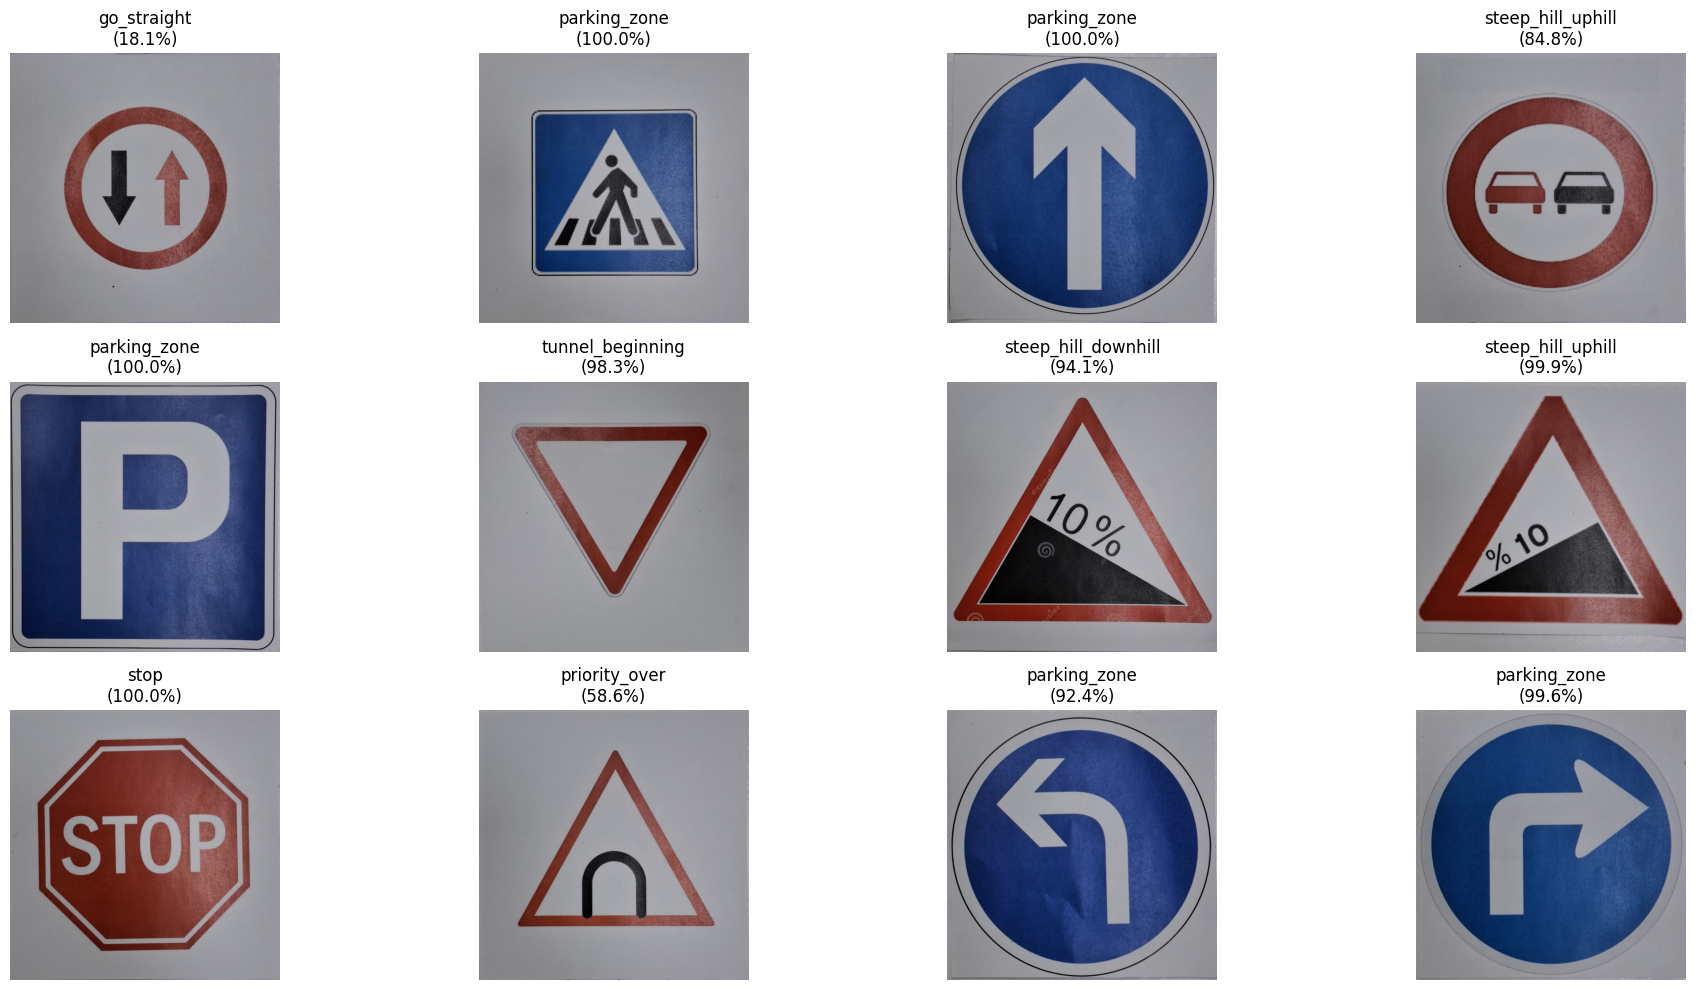

In [ ]:
model_path = "best_model.pth"
test_path = "test"

test_single_image(model_path, test_path)